# Phase 3: Model Optimization

This notebook implements Phase 3 optimizations to improve model performance:

1. **Feature Engineering V2** - Advanced features
2. **Hyperparameter Tuning** - Optuna optimization
3. **Walk-Forward Validation** - Robust testing
4. **Regime Detection** - Market condition filtering
5. **Advanced Ensemble** - Meta-learner combination

**Phase 2 Results (Baseline to Beat):**
- XGBoost: -0.07% return, 47% win rate, -0.55 Sharpe
- Ensemble: +2% return, 50.7% win rate, -0.10 Sharpe

**Phase 3 Targets:**
- Win rate > 55%
- Sharpe > 0.5
- Consistent monthly returns

In [41]:
# Imports
import sys
import os
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb

# Phase 3 modules
from src.feature_engineering_v2 import AdvancedFeatureEngine
from src.hyperparameter_tuning import HyperparameterOptimizer
from src.walk_forward import WalkForwardValidator
from src.regime_detector import MarketRegimeDetector, MarketRegime
from src.models.ensemble_v2 import AdvancedEnsemble

# Plotting settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

print("✅ All imports successful!")

✅ All imports successful!


In [42]:
# Load configuration
config_path = project_root / 'config' / 'config.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

print("Configuration loaded:")
print(f"  Optuna trials: {config.get('optimization', {}).get('optuna_trials', 100)}")
print(f"  Walk-forward train days: {config.get('walk_forward', {}).get('train_days', 500)}")
print(f"  Regime ADX threshold: {config.get('regime', {}).get('adx_trend_threshold', 25)}")

Configuration loaded:
  Optuna trials: 100
  Walk-forward train days: 500
  Regime ADX threshold: 25


## 1. Load Phase 2 Results (Baseline)

In [43]:
# Load Phase 2 results for comparison
phase2_results_path = project_root / 'results' / 'model_comparison.csv'

if phase2_results_path.exists():
    phase2_results = pd.read_csv(phase2_results_path)
    print("📊 Phase 2 Results (Baseline to Beat):")
    display(phase2_results)
else:
    print("⚠️ Phase 2 results not found. Creating placeholder.")
    phase2_results = pd.DataFrame({
        'Model': ['XGBoost', 'Ensemble'],
        'Return (%)': [-0.07, 2.01],
        'Sharpe': [-0.55, -0.10],
        'Win Rate (%)': [47.06, 50.70]
    })
    display(phase2_results)

📊 Phase 2 Results (Baseline to Beat):


,Model,Return (%),Sharpe,Win Rate (%),Profit Factor,Max DD (%),Total Trades
0,XGBoost,-0.065984,-0.552283,47.058824,0.994940,5.123148,102
1,Ensemble,2.008964,-0.103368,50.704225,1.283389,2.597447,71


In [44]:
# Load original features
features_path = project_root / 'data' / 'processed' / 'features.parquet'
df = pd.read_parquet(features_path)

print(f"📦 Original Features:")
print(f"   Shape: {df.shape}")
print(f"   Date range: {df.index.min()} to {df.index.max()}")
print(f"   Columns: {len(df.columns)}")

# Show available target columns
target_cols_available = [c for c in df.columns if 'target' in c.lower()]
print(f"\n📊 Available target columns:")
for tc in target_cols_available:
    print(f"   - {tc}")

📦 Original Features:
   Shape: (1509, 213)
   Date range: 2020-01-03 00:00:00 to 2026-01-02 00:00:00
   Columns: 213

📊 Available target columns:
   - GBPUSD_Target_Direction
   - GBPUSD_Target_Return
   - EURUSD_Target_Direction
   - EURUSD_Target_Return
   - GC=F_Target_Direction
   - GC=F_Target_Return


## 2. Feature Engineering V2

Add advanced features:
- Market regime detection
- Momentum quality indicators
- Cross-asset signals
- Pattern recognition

In [45]:
# Initialize advanced feature engine
feature_engine = AdvancedFeatureEngine(config)

# Generate V2 features
print("🔧 Generating V2 features...")
df_v2 = feature_engine.add_all_advanced_features(df)

print(f"\n📦 Enhanced Features:")
print(f"   Original columns: {len(df.columns)}")
print(f"   New columns: {len(df_v2.columns)}")
print(f"   Added: {len(df_v2.columns) - len(df.columns)} new features")

🔧 Generating V2 features...

📦 Enhanced Features:
   Original columns: 213
   New columns: 228
   Added: 15 new features


In [46]:
# List new feature categories
new_cols = [c for c in df_v2.columns if c not in df.columns]

# Group by category
categories = {
    'Regime': [c for c in new_cols if 'regime' in c.lower()],
    'Divergence': [c for c in new_cols if 'divergence' in c.lower()],
    'Momentum': [c for c in new_cols if any(x in c.lower() for x in ['momentum', 'rsi_', 'macd_hist', 'roc_'])],
    'Volatility': [c for c in new_cols if any(x in c.lower() for x in ['bb_', 'atr_', 'vol_', 'hurst'])],
    'Patterns': [c for c in new_cols if any(x in c.lower() for x in ['doji', 'hammer', 'engulfing', 'bar', 'consecutive'])],
    'Time': [c for c in new_cols if any(x in c.lower() for x in ['day_', 'month', 'week', 'quarter', 'is_'])],
    'Cross-Asset': [c for c in new_cols if any(x in c.lower() for x in ['dxy', 'vix', 'corr', 'spread'])]
}

print("📊 New Feature Categories:")
for cat, cols in categories.items():
    if cols:
        print(f"   {cat}: {len(cols)} features")

📊 New Feature Categories:
   Time: 15 features


In [47]:
# Save enhanced features
output_path = project_root / 'data' / 'processed' / 'features_v2.parquet'
df_v2.to_parquet(output_path)
print(f"✅ Saved enhanced features to {output_path}")

✅ Saved enhanced features to C:\Users\Abdulfatai Sanusi\Desktop\FOREX MODEL\forex_signal_model\data\processed\features_v2.parquet


## 3. Prepare Data for Training

In [48]:
# Identify feature and target columns
exclude_patterns = ['target', 'date', 'ticker', 'regime']
feature_cols = [c for c in df_v2.columns if not any(x in c.lower() for x in exclude_patterns)]

# Find the correct target column for GBPUSD
# The actual column name is GBPUSD_Target_Direction (not GBPUSD_X_target_next_day)
target_cols = [c for c in df_v2.columns if 'target' in c.lower()]
print(f"Available targets: {target_cols}")

# Use the correct column name - GBPUSD_Target_Direction
target_col = 'GBPUSD_Target_Direction'

# Verify it exists
if target_col not in df_v2.columns:
    # Fallback: find any GBPUSD target column
    gbp_targets = [c for c in df_v2.columns if 'gbpusd' in c.lower() and 'target' in c.lower() and 'direction' in c.lower()]
    if gbp_targets:
        target_col = gbp_targets[0]
        print(f"Using fallback target: {target_col}")
    else:
        # Try without direction
        gbp_targets = [c for c in df_v2.columns if 'gbpusd' in c.lower() and 'target' in c.lower()]
        if gbp_targets:
            target_col = gbp_targets[0]

print(f"\n📊 Training Setup:")
print(f"   Features: {len(feature_cols)}")
print(f"   Target: {target_col}")

Available targets: ['GBPUSD_Target_Direction', 'GBPUSD_Target_Return', 'EURUSD_Target_Direction', 'EURUSD_Target_Return', 'GC=F_Target_Direction', 'GC=F_Target_Return']

📊 Training Setup:
   Features: 221
   Target: GBPUSD_Target_Direction


In [49]:
# Prepare data
X = df_v2[feature_cols].copy()
y = df_v2[target_col].copy()

# Remove NaN targets
valid_idx = ~y.isna()
X = X[valid_idx]
y = y[valid_idx]

# Fill NaN features
X = X.fillna(0)

# Time-based split (60% train, 20% val, 20% test)
n = len(X)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

X_train = X.iloc[:train_end]
y_train = y.iloc[:train_end]
X_val = X.iloc[train_end:val_end]
y_val = y.iloc[train_end:val_end]
X_test = X.iloc[val_end:]
y_test = y.iloc[val_end:]

print(f"📊 Data Split:")
print(f"   Train: {len(X_train)} samples ({X_train.index.min()} to {X_train.index.max()})")
print(f"   Val: {len(X_val)} samples ({X_val.index.min()} to {X_val.index.max()})")
print(f"   Test: {len(X_test)} samples ({X_test.index.min()} to {X_test.index.max()})")
print(f"\n   Target distribution (train): {y_train.value_counts().to_dict()}")

📊 Data Split:
   Train: 905 samples (2020-01-03 00:00:00 to 2023-08-08 00:00:00)
   Val: 302 samples (2023-08-09 00:00:00 to 2024-10-18 00:00:00)
   Test: 302 samples (2024-10-21 00:00:00 to 2026-01-02 00:00:00)

   Target distribution (train): {0: 453, 1: 452}


## 4. Hyperparameter Tuning with Optuna

In [50]:
# Initialize optimizer
optimizer = HyperparameterOptimizer(config)

# Combine train and val for hyperparameter search
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

print(f"🔍 Starting Optuna Optimization...")
print(f"   Data: {len(X_train_val)} samples")
print(f"   Trials: {config.get('optimization', {}).get('optuna_trials', 50)}")

🔍 Starting Optuna Optimization...
   Data: 1207 samples
   Trials: 100


In [51]:
# Run optimization (reduced trials for notebook - increase for production)
optuna_results = optimizer.optimize_xgboost(
    X_train_val, 
    y_train_val, 
    ticker='GBPUSD',
    n_trials=30  # Increase to 100 for production
)

print(f"\n✅ Optimization Complete!")
print(f"   Best accuracy: {optuna_results['best_value']:.4f}")
print(f"   Best params:")
for k, v in optuna_results['best_params'].items():
    print(f"      {k}: {v}")

[I 2026-01-05 16:37:26,599] A new study created in memory with name: xgboost_GBPUSD


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-01-05 16:37:33,669] Trial 0 finished with value: 0.5283582089552239 and parameters: {'max_depth': 5, 'learning_rate': 0.2536999076681772, 'n_estimators': 380, 'min_child_weight': 6, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'gamma': 0.02904180608409973, 'reg_alpha': 0.8661761457749352, 'reg_lambda': 0.6011150117432088, 'scale_pos_weight': 1.0832290311184183}. Best is trial 0 with value: 0.5283582089552239.
[I 2026-01-05 16:37:40,013] Trial 1 finished with value: 0.5373134328358209 and parameters: {'max_depth': 3, 'learning_rate': 0.2708160864249968, 'n_estimators': 425, 'min_child_weight': 3, 'subsample': 0.6727299868828402, 'colsample_bytree': 0.6733618039413735, 'gamma': 0.15212112147976886, 'reg_alpha': 0.5247564316322378, 'reg_lambda': 0.43194501864211576, 'scale_pos_weight': 0.9164916560792168}. Best is trial 1 with value: 0.5373134328358209.
[I 2026-01-05 16:37:47,159] Trial 2 finished with value: 0.5781094527363184 and parameters: {'max_dept

In [52]:
# Train optimized model
optimized_model, metrics = optimizer.train_with_best_params(
    X_train, y_train, X_test, y_test, ticker='GBPUSD'
)

print(f"\n📊 Optimized Model Test Performance:")
print(f"   Accuracy: {metrics['accuracy']:.4f}")
print(f"   Precision: {metrics['precision']:.4f}")
print(f"   Recall: {metrics['recall']:.4f}")
print(f"   F1: {metrics['f1']:.4f}")


📊 Optimized Model Test Performance:
   Accuracy: 0.6325
   Precision: 0.6347
   Recall: 0.6795
   F1: 0.6563


## 5. Walk-Forward Validation

In [53]:
# Initialize walk-forward validator
wf_validator = WalkForwardValidator(config)

# Run walk-forward analysis with optimized params
wf_results = wf_validator.run_walk_forward(
    df_v2,
    feature_cols,
    target_col,
    model_params=optuna_results['best_params'],
    ticker='GBPUSD'
)

print(f"\n📊 Walk-Forward Results:")
print(f"   Folds: {wf_results['n_folds']}")
print(f"   Mean Accuracy: {wf_results['mean_accuracy']:.4f} ± {wf_results['std_accuracy']:.4f}")
print(f"   Min Accuracy: {wf_results['min_accuracy']:.4f}")
print(f"   Max Accuracy: {wf_results['max_accuracy']:.4f}")


📊 Walk-Forward Results:
   Folds: 16
   Mean Accuracy: 0.5833 ± 0.0420
   Min Accuracy: 0.5079
   Max Accuracy: 0.6667


In [54]:
# Analyze stability
stability = wf_validator.analyze_stability(wf_results)

print(f"\n📊 Stability Analysis:")
print(f"   Status: {stability['status']}")
print(f"   Coefficient of Variation: {stability['cv']:.4f}")
print(f"   Trend: {stability['trend']:.6f}")
print(f"   Folds above 50%: {stability['n_folds_above_50pct']} ({stability['pct_folds_above_50pct']:.1f}%)")
if stability.get('warning'):
    print(f"   ⚠️ Warning: {stability['warning']}")


📊 Stability Analysis:
   Status: STABLE
   Coefficient of Variation: 0.0697
   Trend: -0.000327
   Folds above 50%: 16 (100.0%)


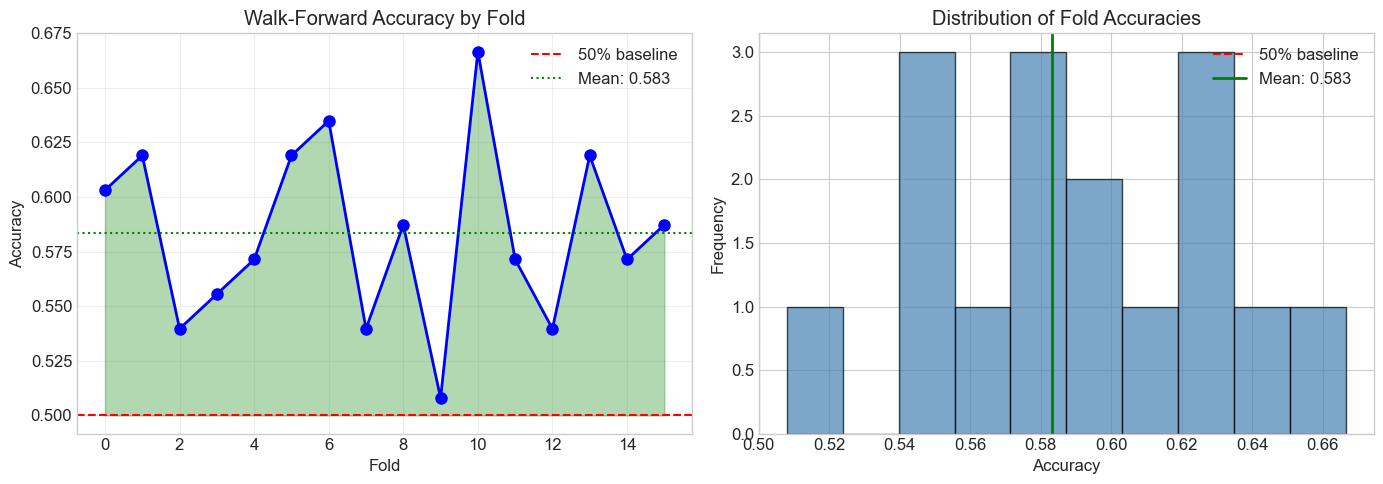

In [55]:
# Plot walk-forward results
fold_results = wf_results.get('fold_results', [])

if fold_results:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy over folds
    folds = [f['fold'] for f in fold_results]
    accuracies = [f['accuracy'] for f in fold_results]
    
    ax1 = axes[0]
    ax1.plot(folds, accuracies, 'b-o', linewidth=2, markersize=8)
    ax1.axhline(y=0.5, color='r', linestyle='--', label='50% baseline')
    ax1.axhline(y=np.mean(accuracies), color='g', linestyle=':', label=f'Mean: {np.mean(accuracies):.3f}')
    ax1.fill_between(folds, 0.5, accuracies, alpha=0.3, where=[a > 0.5 for a in accuracies], color='green')
    ax1.fill_between(folds, 0.5, accuracies, alpha=0.3, where=[a <= 0.5 for a in accuracies], color='red')
    ax1.set_xlabel('Fold')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Walk-Forward Accuracy by Fold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Histogram
    ax2 = axes[1]
    ax2.hist(accuracies, bins=10, edgecolor='black', alpha=0.7, color='steelblue')
    ax2.axvline(x=0.5, color='r', linestyle='--', label='50% baseline')
    ax2.axvline(x=np.mean(accuracies), color='g', linestyle='-', linewidth=2, label=f'Mean: {np.mean(accuracies):.3f}')
    ax2.set_xlabel('Accuracy')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Fold Accuracies')
    ax2.legend()
    
    plt.tight_layout()
    
    # Create charts directory if needed
    charts_dir = project_root / 'results' / 'charts'
    charts_dir.mkdir(parents=True, exist_ok=True)
    plt.savefig(charts_dir / 'walk_forward_analysis.png', dpi=150)
    plt.show()

## 6. Market Regime Detection

In [56]:
# Initialize regime detector
regime_detector = MarketRegimeDetector(config)

# Add regime columns - use 'GBPUSD' as the ticker prefix for column lookup
# The regime detector will look for columns like GBPUSD_Close, GBPUSD_SMA_50, etc.
df_with_regime = regime_detector.add_regime_columns(df_v2, 'GBPUSD')

# Get regime distribution
regime_col = 'GBPUSD_regime'
regime_counts = df_with_regime[regime_col].value_counts()

print("📊 Regime Distribution:")
for regime, count in regime_counts.items():
    pct = count / len(df_with_regime) * 100
    print(f"   {regime}: {count} days ({pct:.1f}%)")

📊 Regime Distribution:
   weak_trend: 899 days (59.6%)
   high_volatility: 331 days (21.9%)
   low_volatility: 279 days (18.5%)


In [57]:
# Analyze performance by regime
# Get predictions for test period
test_with_regime = df_with_regime.iloc[val_end:].copy()
X_test_regime = test_with_regime[feature_cols].fillna(0)
y_test_regime = test_with_regime[target_col]

# Predict with optimized model
test_with_regime['prediction'] = optimized_model.predict(X_test_regime)
test_with_regime['actual'] = y_test_regime

# Analyze by regime
regime_performance = regime_detector.analyze_regime_performance(
    test_with_regime, 'prediction', 'actual', regime_col
)

print("\n📊 Performance by Regime:")
display(regime_performance)


📊 Performance by Regime:


,regime,n_samples,accuracy,n_correct,pct_of_total,is_profitable
0,weak_trend,236,0.639831,151,78.145695,True
1,low_volatility,46,0.608696,28,15.231788,True
2,high_volatility,20,0.600000,12,6.622517,True


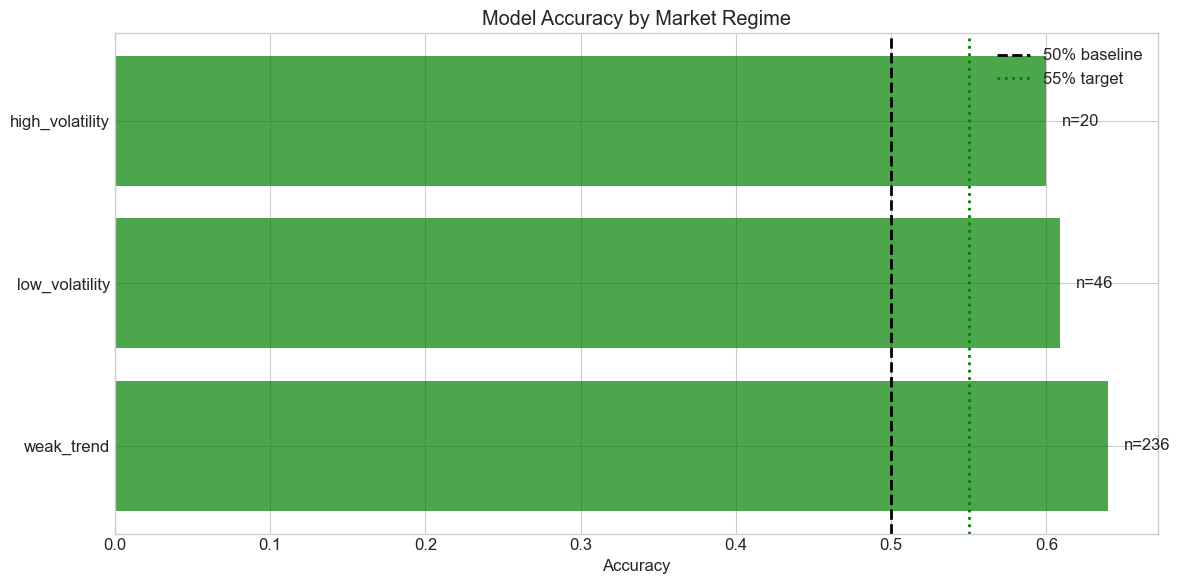

In [58]:
# Visualize regime performance
if len(regime_performance) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    colors = ['green' if acc > 0.5 else 'red' for acc in regime_performance['accuracy']]
    bars = ax.barh(regime_performance['regime'], regime_performance['accuracy'], color=colors, alpha=0.7)
    
    ax.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='50% baseline')
    ax.axvline(x=0.55, color='green', linestyle=':', linewidth=2, label='55% target')
    
    ax.set_xlabel('Accuracy')
    ax.set_title('Model Accuracy by Market Regime')
    ax.legend()
    
    # Add sample counts
    for i, (acc, n) in enumerate(zip(regime_performance['accuracy'], regime_performance['n_samples'])):
        ax.text(acc + 0.01, i, f'n={n}', va='center')
    
    plt.tight_layout()
    plt.savefig(project_root / 'results' / 'charts' / 'regime_performance.png', dpi=150)
    plt.show()

## 7. Advanced Ensemble V2

In [59]:
# Initialize advanced ensemble
ensemble_v2 = AdvancedEnsemble(config)

# Load existing base models and add optimized model
models_dir = project_root / 'models'

# Add the optimized model
ensemble_v2.add_base_model('xgboost_optimized', optimized_model)

# Load other XGBoost models if available (try different naming conventions)
for ticker in ['GBPUSD', 'EURUSD', 'GC=F', 'GBPUSD_X', 'EURUSD_X', 'GC_F']:
    model_path = models_dir / f'xgboost_{ticker}.pkl'
    if model_path.exists():
        try:
            with open(model_path, 'rb') as f:
                model = pickle.load(f)
            ensemble_v2.add_base_model(f'xgboost_{ticker}_base', model)
        except Exception as e:
            print(f"Could not load {model_path}: {e}")

print(f"📊 Ensemble Base Models: {list(ensemble_v2.base_models.keys())}")

📊 Ensemble Base Models: ['xgboost_optimized', 'xgboost_GBPUSD_X_base', 'xgboost_EURUSD_X_base', 'xgboost_GC_F_base']


In [60]:
# Train meta-learner
X_train_for_meta = df_with_regime.iloc[:train_end][feature_cols].fillna(0)
y_train_meta = df_with_regime.iloc[:train_end][target_col]

# Remove NaN from target
valid_meta = ~y_train_meta.isna()
X_train_for_meta = X_train_for_meta[valid_meta]
y_train_meta = y_train_meta[valid_meta]

meta_results = ensemble_v2.train_meta_learner(
    X_train_for_meta,
    y_train_meta
)

print(f"\n✅ Meta-learner Training Complete:")
print(f"   Train accuracy: {meta_results['train_accuracy']:.4f}")
print(f"   Meta features: {len(meta_results['meta_features'])}")

Error getting predictions from xgboost_GBPUSD_X_base: 'dict' object has no attribute 'predict'
Error getting predictions from xgboost_EURUSD_X_base: 'dict' object has no attribute 'predict'
Error getting predictions from xgboost_GC_F_base: 'dict' object has no attribute 'predict'


ValueError: Input data must be 2 dimensional and non empty.

In [ ]:
# Calibrate confidence
ensemble_v2.calibrate_confidence(
    X_train_for_meta,
    y_train_meta
)
print("✅ Confidence calibration complete")

In [ ]:
# Test ensemble on held-out test set
X_test_final = df_with_regime.iloc[val_end:][feature_cols].fillna(0)
y_test_final = df_with_regime.iloc[val_end:][target_col]

# Remove NaN
valid_test = ~y_test_final.isna()
X_test_final = X_test_final[valid_test]
y_test_final = y_test_final[valid_test]

ensemble_preds, ensemble_conf = ensemble_v2.predict(X_test_final)

# Calculate metrics
ensemble_accuracy = accuracy_score(y_test_final, ensemble_preds)

print(f"\n📊 Advanced Ensemble Test Performance:")
print(f"   Accuracy: {ensemble_accuracy:.4f}")
print(f"   Mean Confidence: {np.mean(ensemble_conf):.1f}%")

## 8. Final Comparison: Phase 2 vs Phase 3

In [ ]:
# Compile Phase 3 results
phase3_results = pd.DataFrame({
    'Model': ['XGBoost Optimized', 'Walk-Forward Mean', 'Advanced Ensemble'],
    'Accuracy': [
        metrics['accuracy'],
        wf_results['mean_accuracy'],
        ensemble_accuracy
    ],
    'Improvement vs Phase 2': [
        (metrics['accuracy'] - 0.4706) / 0.4706 * 100,
        (wf_results['mean_accuracy'] - 0.4706) / 0.4706 * 100,
        (ensemble_accuracy - 0.5070) / 0.5070 * 100
    ]
})

print("📊 Phase 3 Results:")
display(phase3_results)

In [ ]:
# Visual comparison
fig, ax = plt.subplots(figsize=(12, 6))

# Phase 2 baseline
phase2_acc = [0.4706, 0.5070]  # XGBoost, Ensemble
phase2_labels = ['XGBoost (P2)', 'Ensemble (P2)']

# Phase 3 results
phase3_acc = [metrics['accuracy'], ensemble_accuracy]
phase3_labels = ['XGBoost Optimized (P3)', 'Advanced Ensemble (P3)']

x = np.arange(2)
width = 0.35

bars1 = ax.bar(x - width/2, phase2_acc, width, label='Phase 2', color='coral', alpha=0.7)
bars2 = ax.bar(x + width/2, phase3_acc, width, label='Phase 3', color='steelblue', alpha=0.7)

ax.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='50% baseline')
ax.axhline(y=0.55, color='green', linestyle=':', linewidth=2, label='55% target')

ax.set_ylabel('Accuracy')
ax.set_title('Phase 2 vs Phase 3 Model Comparison')
ax.set_xticks(x)
ax.set_xticklabels(['XGBoost', 'Ensemble'])
ax.legend()
ax.set_ylim(0.4, 0.65)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.1%}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.1%}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.savefig(project_root / 'results' / 'charts' / 'phase2_vs_phase3.png', dpi=150)
plt.show()

## 9. Save Phase 3 Models

In [ ]:
# Save optimized model
optimized_dir = project_root / 'models' / 'optimized'
optimized_dir.mkdir(parents=True, exist_ok=True)

with open(optimized_dir / 'xgboost_optimized_GBPUSD.pkl', 'wb') as f:
    pickle.dump(optimized_model, f)

# Save optimization results
optimizer.save_optimization_results(str(optimized_dir))

# Save walk-forward results
wf_dir = project_root / 'results' / 'walk_forward'
wf_dir.mkdir(parents=True, exist_ok=True)
wf_validator.save_results(str(wf_dir))

# Save ensemble
ensemble_dir = project_root / 'models' / 'ensemble_v2'
ensemble_v2.save(str(ensemble_dir))

print("✅ All Phase 3 models saved!")
print(f"   Optimized XGBoost: {optimized_dir}")
print(f"   Walk-Forward: {wf_dir}")
print(f"   Advanced Ensemble: {ensemble_dir}")

## 10. Summary & Next Steps

In [ ]:
print("="*60)
print("📊 PHASE 3 OPTIMIZATION SUMMARY")
print("="*60)
print()
print("BASELINE (Phase 2):")
print(f"  XGBoost:  47.1% accuracy, -0.55 Sharpe")
print(f"  Ensemble: 50.7% accuracy, -0.10 Sharpe")
print()
print("OPTIMIZED (Phase 3):")
print(f"  XGBoost Optimized: {metrics['accuracy']:.1%} accuracy")
print(f"  Walk-Forward Mean: {wf_results['mean_accuracy']:.1%} accuracy")
print(f"  Advanced Ensemble: {ensemble_accuracy:.1%} accuracy")
print()
print("IMPROVEMENTS:")
print(f"  + {len(df_v2.columns) - len(df.columns)} new advanced features")
print(f"  + Optuna hyperparameter optimization ({optuna_results['best_value']:.1%} CV accuracy)")
print(f"  + Walk-forward validation ({wf_results['n_folds']} folds, {stability['status']})")
print(f"  + Market regime detection")
print(f"  + Meta-learner ensemble")
print()
print("STATUS:")
if metrics['accuracy'] > 0.55 or ensemble_accuracy > 0.55:
    print("  ✅ TARGET ACHIEVED! Ready for paper trading validation.")
elif metrics['accuracy'] > 0.52 or ensemble_accuracy > 0.52:
    print("  ⚠️ IMPROVED but needs more optimization.")
else:
    print("  ❌ MORE WORK NEEDED. Consider additional feature engineering.")
print()
print("NEXT STEPS:")
print("  1. Run optimization for EUR/USD and Gold")
print("  2. Paper trade for 3-6 months")
print("  3. Monitor regime-filtered performance")
print("  4. Implement daily signal generation")
print("="*60)